In [1]:
# ===============================
# 0. Imports & plotting setup
# ===============================
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from sklearn.metrics import r2_score, mean_absolute_error
from scipy.stats import pearsonr, spearmanr
from lifelines.utils import concordance_index
import os

# --- Matplotlib settings
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rcParams['font.family'] = 'DejaVu Sans'

sns.set(style="white", context="talk", font_scale=1.1)
%matplotlib inline


In [2]:
import pickle

model_path = "/home/nilabjab/cancer_dependency_project_nilabja/cancer_dependency_project/Approach3_Latent_factor/git_repo/Models/daporinad_new_splits/DAPORINAD_NAMPT_forgeModel_rankedHP_321456.pkl"

with open(model_path, "rb") as f:
    model = pickle.load(f)

print(type(model))


<class 'forge_class_instance5.FORGE'>


In [3]:
[attr for attr in dir(model) if not attr.startswith("_")]


['W',
 'best_hyperparams',
 'dep_data',
 'dep_path',
 'drug',
 'exp_data',
 'exp_hcg',
 'exp_path',
 'get_best_hyperparams_original',
 'get_train_val_test_kSplits',
 'hD',
 'hI',
 'hcg_list',
 'hyperparam_tuner',
 'ic50_data',
 'ic50_path',
 'initialise_model',
 'load_forge',
 'losses_path',
 'mean_dep',
 'mean_exp',
 'mean_ic50',
 'report_metrics',
 'run_Pipeline',
 'save_forge',
 'std_exp',
 'target',
 'test_cellLines',
 'test_predictions_IC50',
 'test_predictions_dep',
 'test_res',
 'train_cellLines',
 'train_forge',
 'train_instance',
 'train_predictions_IC50',
 'train_predictions_dep',
 'training_cv_splits',
 'validate_instance']

In [4]:
model_attrs = [attr for attr in dir(model) if not attr.startswith("_")]
for a in model_attrs:
    print(a)


W
best_hyperparams
dep_data
dep_path
drug
exp_data
exp_hcg
exp_path
get_best_hyperparams_original
get_train_val_test_kSplits
hD
hI
hcg_list
hyperparam_tuner
ic50_data
ic50_path
initialise_model
load_forge
losses_path
mean_dep
mean_exp
mean_ic50
report_metrics
run_Pipeline
save_forge
std_exp
target
test_cellLines
test_predictions_IC50
test_predictions_dep
test_res
train_cellLines
train_forge
train_instance
train_predictions_IC50
train_predictions_dep
training_cv_splits
validate_instance


In [5]:
exp_data = pd.read_csv(model.exp_path, header = 0, index_col = 0)
dep_data = pd.read_csv(model.dep_path, header = 0, index_col = 0)
ic50_data = pd.read_csv(model.ic50_path, header = 0, index_col = 0)
ic50_data = model.ic50_data.T
exp_data.shape, dep_data.shape, ic50_data.shape

((1076, 16289), (1076, 17916), (1325, 187))

In [6]:
common_cellLines = list(set(exp_data.index) & set(dep_data.index) & set(ic50_data.index))
len(common_cellLines)

700

In [7]:
exp_data_subset = exp_data.loc[common_cellLines, model.hcg_list].drop_duplicates(keep='first')
dep_target = dep_data.loc[common_cellLines, model.target].dropna().drop_duplicates(keep='first')
drug_ic50 = ic50_data.loc[common_cellLines, model.drug].dropna().drop_duplicates(keep='first')
exp_data_subset = exp_data.loc[dep_target.index, model.hcg_list]
drug_ic50 = ic50_data.loc[dep_target.index, model.drug]
exp_data_subset.shape, dep_target.shape, drug_ic50.shape

((697, 199), (697,), (697,))

In [8]:
model.exp_data = exp_data_subset
model.dep_data = dep_target
model.ic50_data = drug_ic50
model.exp_data.shape, model.dep_data.shape, model.ic50_data.shape

((697, 199), (697,), (697,))

In [9]:
common_train_cellLines = list(set(model.train_cellLines) & set(model.exp_data.index))
common_test_cellLines = list(set(model.test_cellLines) & set(model.exp_data.index))

In [10]:
G_train = model.exp_data.loc[common_train_cellLines, :].to_numpy()
G_test  = model.exp_data.loc[common_test_cellLines, :].to_numpy()

D_train = model.dep_data.loc[common_train_cellLines].to_numpy().reshape(-1, 1)
D_test  = model.dep_data.loc[common_test_cellLines].to_numpy().reshape(-1, 1)       
I_train = model.ic50_data.loc[common_train_cellLines].to_numpy().reshape(-1, 1)
I_test  = model.ic50_data.loc[common_test_cellLines].to_numpy().reshape(-1, 1)

G_train.shape, D_train.shape, I_train.shape, G_test.shape, D_test.shape, I_test.shape

((517, 199), (517, 1), (517, 1), (130, 199), (130, 1), (130, 1))

In [11]:
# Latent embeddings
Z_train = G_train @ model.W
Z_test  = G_test  @ model.W

# Predictions
pred_D_train = Z_train @ model.hD
pred_D_test  = Z_test  @ model.hD

pred_I_train = Z_train @ model.hI
pred_I_test  = Z_test  @ model.hI

In [31]:
# === Plot aesthetics
sns.set(style="white", context="talk", font_scale=1.1)

def annotate_and_regress(ax, x, y, title, xlabel, ylabel):
    x = x.flatten()
    y = y.flatten()

    pearson_corr, _ = pearsonr(x, y)
    spearman_corr, _ = spearmanr(x, y)
    r2 = r2_score(x, y)
    mae = mean_absolute_error(x, y)
    ci = concordance_index(x, y)
    
    sns.regplot(
        x=x,
        y=y,
        ax=ax,
        color='darkslategrey',  # Line + CI color
        scatter_kws={'s': 40, 'alpha': 1, 'color': 'seagreen','rasterized': True, 'edgecolors': 'black', 'linewidths': 0.1},
        line_kws={'color': 'darkslategrey'},
        ci=100
    )

    ax.set_title(title, fontsize=16)
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)

    metrics = (
        f"Pearson r   = {pearson_corr:.2f}\n"
        f"Spearman ρ  = {spearman_corr:.2f}\n"
        f"R² Score    = {r2:.2f}\n"
        f"MAE         = {mae:.2f}\n"
        f"C-Index     = {ci:.2f}"
    )

    ax.text(
        0.05, 0.95, metrics,
        transform=ax.transAxes,
        fontsize=11,
        va="top", ha='left',
        bbox=dict(boxstyle="round", fc="white", ec="grey", alpha=0.9)
    )

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.tick_params(axis='both', which='both', bottom=True, top=False, left=True, right=False)
    ax.tick_params(axis='both', which='major', labelsize=12)

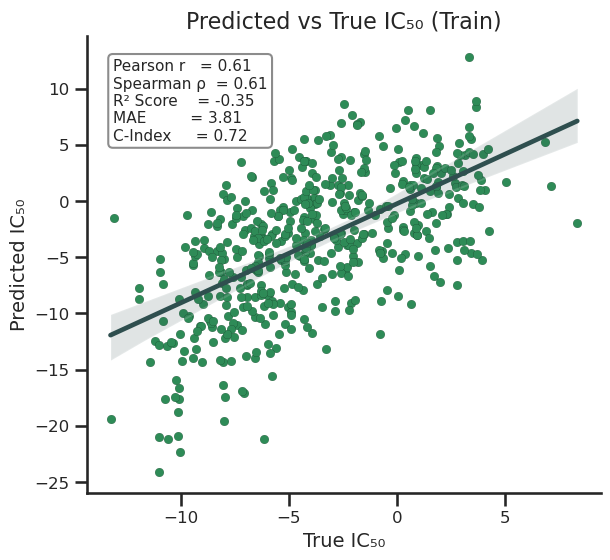

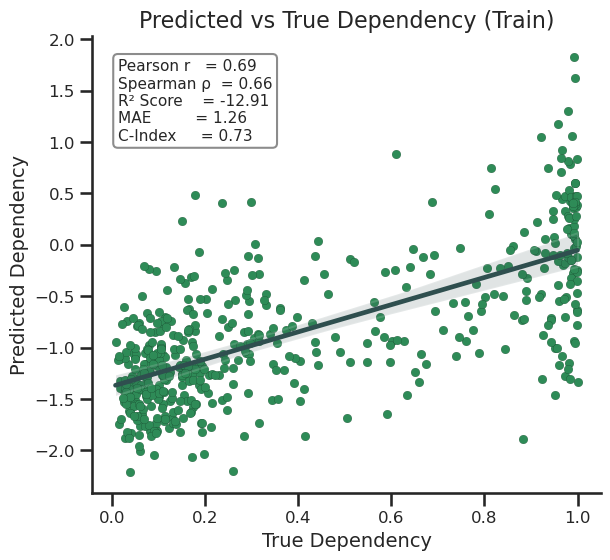

In [32]:
fig1, ax1 = plt.subplots(figsize=(6.5, 6))
annotate_and_regress(
    ax1,
    I_train,
    pred_I_train,
    "Predicted vs True IC₅₀ (Train)",
    "True IC₅₀",
    "Predicted IC₅₀"
)
plt.tight_layout()
fig1.savefig("/home/nilabjab/cancer_dependency_project_nilabja/cancer_dependency_project/Approach3_Latent_factor/git_repo/Figs/Fig5/pred_vs_true_ic50_train_Daporinad.pdf", dpi=300, bbox_inches='tight')  # 💾 Save the figure
plt.show()

fig2, ax2 = plt.subplots(figsize=(6.5, 6))
annotate_and_regress(
    ax2,
    D_train,
    pred_D_train,
    "Predicted vs True Dependency (Train)",
    "True Dependency",
    "Predicted Dependency"
)
plt.tight_layout()
fig2.savefig("/home/nilabjab/cancer_dependency_project_nilabja/cancer_dependency_project/Approach3_Latent_factor/git_repo/Figs/Fig5/pred_vs_true_dep_train_Daporinad.pdf", dpi=300, bbox_inches='tight')  # 💾 Save the figure
plt.show()



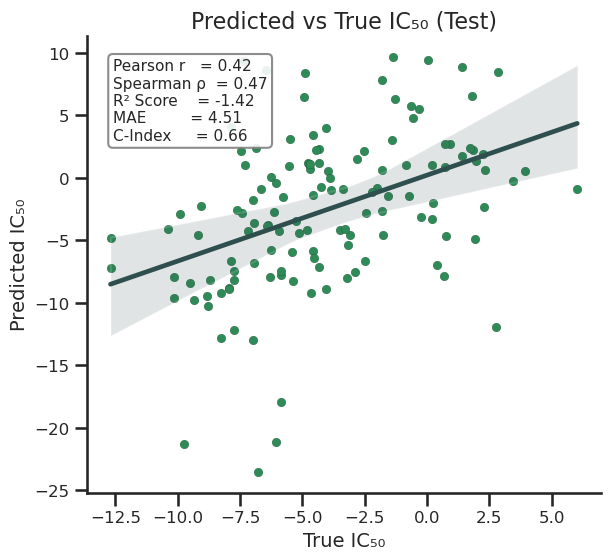

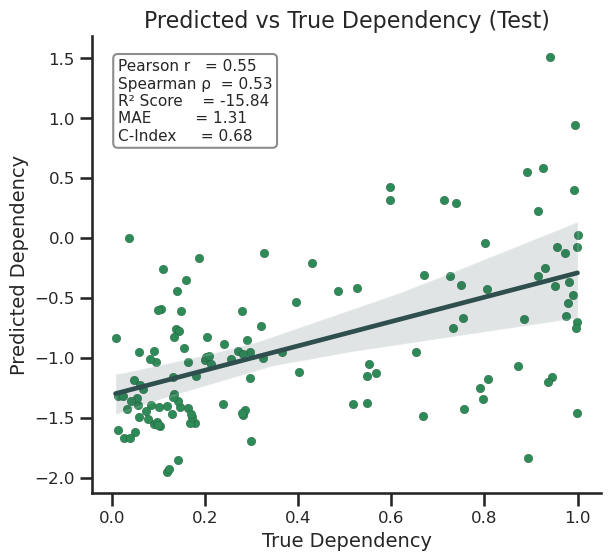

In [33]:
fig3, ax3 = plt.subplots(figsize=(6.5, 6))
annotate_and_regress(
    ax3,
    I_test,
    pred_I_test,
    "Predicted vs True IC₅₀ (Test)",
    "True IC₅₀",
    "Predicted IC₅₀"
)
plt.tight_layout()
fig3.savefig("/home/nilabjab/cancer_dependency_project_nilabja/cancer_dependency_project/Approach3_Latent_factor/git_repo/Figs/Fig5/pred_vs_true_ic50_test_Daporinad.pdf", dpi=300, bbox_inches='tight')  # 💾 Save the figure
plt.show()

fig4, ax4 = plt.subplots(figsize=(6.5, 6))
annotate_and_regress(
    ax4,
    D_test,
    pred_D_test,
    "Predicted vs True Dependency (Test)",
    "True Dependency",
    "Predicted Dependency"
)
plt.tight_layout()
fig4.savefig("/home/nilabjab/cancer_dependency_project_nilabja/cancer_dependency_project/Approach3_Latent_factor/git_repo/Figs/Fig5/pred_vs_true_dep_test_Daporinad.pdf", dpi=300, bbox_inches='tight')  # 💾 Save the figure
plt.show()

